In [171]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor, cv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("dark")
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

In [172]:
#Data loading and cleaning steps
full_data = pd.read_csv('winemag-data-130k-v2.csv')
data = full_data.copy()
print("Total number of examples: ", data.shape[0])
print("Number of examples with the same title and description: ",
      data[data.duplicated(['description','title'])].shape[0])
data=data.drop_duplicates(['description','title'])
data=data.reset_index(drop=True)
data=data.dropna(subset=['price'])
data=data.reset_index(drop=True)

Total number of examples:  129971
Number of examples with the same title and description:  9983


In [173]:
data['description']= data['description'].str.lower()
data['description']= data['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
data['description']


tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = data['description'].apply(tokenizer.tokenize)

all_words = [word for tokens in words_descriptions for word in tokens]
data['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
data['description_cleaned'] = words_descriptions.apply(lambda elem: ' '.join(elem))

4624968 words total, with a vocabulary size of 29486


In [174]:
def prepare_dataframe(vect, data, features=True):
    vectorized=vect.fit_transform(data['description_cleaned']).toarray()
    vectorized=pd.DataFrame(vectorized)
    vectorized.columns = [ name + "_nlp" for name in  vect.get_feature_names()]
    if features == True:
        X=data.drop(columns=['points','Unnamed: 0',
                             'description','description_cleaned', 'designation',
                            'title'])
        X=X.fillna(-1)
        print(X.columns)
        X=pd.concat([X.reset_index(drop=True),vectorized.reset_index(drop=True)],axis=1)
    else:
        X=vectorized
    y=data['points']
    return X,y

def myOneHotEncoder(s, thresh, name):
    d = pd.get_dummies(s)
    f = pd.value_counts(s, sort=False, normalize=True) < thresh
    if f.sum() == 0:
        return d
    else:
        return d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('other_' + name))

In [175]:
categorical_col = {'country' : 0, 
                   'province' : 0.001,
                   'region_1' :0.001,
                   'taster_name' : 0,
                   'taster_twitter_handle' : 0,
                   'variety' :0.01,
                   'winery' :0.01}
for cat, thresh in categorical_col.items():
    cols = myOneHotEncoder(data[cat], thresh, cat)
    data = pd.concat([data, cols], axis=1)

data=data.drop(columns=['region_2'])
data=data.reset_index(drop=True)
data=data.drop(columns=categorical_col.keys())
data=data.reset_index(drop=True)

In [176]:
vect= CountVectorizer(analyzer='word', token_pattern=r'\w+',max_features=500)
X,y = prepare_dataframe(vect, data)
X.shape

Index(['price', 'description_lengths', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada',
       ...
       'Rosé', 'Sangiovese', 'Sauvignon Blanc', 'Sparkling Blend', 'Syrah',
       'Tempranillo', 'White Blend', 'Zinfandel', 'other_variety',
       'other_winery'],
      dtype='object', length=354)


(111593, 854)

In [177]:

from sklearn.preprocessing import StandardScaler
copy_x = X.copy()

col_names = ['price', 'description_lengths']
features = copy_x[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
copy_x[col_names] = features
copy_x.shape, y.shape

((111593, 854), (111593,))

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, 
                                                        random_state=42)

In [111]:
from sklearn.linear_model import RidgeCV
alphas = [0.001, 0.01, 0.1, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 4, 6, 8, 10]
rmse = [0] * len(alphas)
coefs = []
for idx, alpha in enumerate(alphas):
    reg = RidgeCV(cv=5, alphas=[alpha]).fit(X_train, y_train)
    pred = reg.predict(X_test)
    rmse[idx] = math.sqrt(mean_squared_error(y_test, pred))
    coefs.append(reg.coef_)

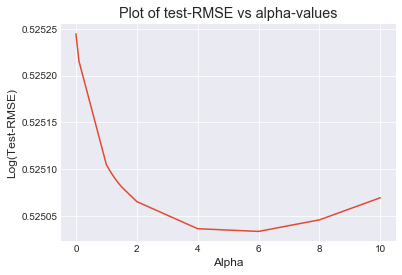

In [112]:
# X_train.columns[np.argsort(reg.coef_)]
plt.style.use(['seaborn-darkgrid'])
plt.plot(alphas, np.log(rmse));
plt.title("Plot of test-RMSE vs alpha-values")
plt.xlabel("Alpha")
plt.ylabel("Log(Test-RMSE)")
plt.show()
# print("Lowest alphas[np.argmin(rmse)]

In [179]:
reg = RidgeCV(cv=5).fit(X_train, y_train)
pred = reg.predict(X_test)
print(truncate(math.sqrt(mean_squared_error(y_test, pred)), 4))

1.6906


In [180]:
reg = RidgeCV(cv=5, alphas=[alphas[np.argmin(rmse)]]).fit(X_train, y_train)
pred = reg.predict(X_test)
print(truncate(math.sqrt(mean_squared_error(y_test, pred)), 4))

1.6905


In [159]:
print(X_train.columns)
print(reg.coef_[0], reg.coef_[1])
coefs_arr = np.array(coefs)
df = pd.DataFrame(coefs_arr[:, 0:5])
df['alphas'] = alphas
columns = X_train.columns[0:5].tolist()
columns.append('alphas')
df.columns = columns
print(df)

Index(['price', 'description_lengths', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada',
       ...
       'wrap_nlp', 'year_nlp', 'yeasti_nlp', 'yellow_nlp', 'yet_nlp',
       'young_nlp', 'youth_nlp', 'zest_nlp', 'zesti_nlp', 'zinfandel_nlp'],
      dtype='object', length=854)
0.011075914580090019 0.0637908193857785
       price  description_lengths  Argentina   Armenia  Australia  alphas
0   0.011012             0.063593   0.057757 -0.898784   1.330893   0.001
1   0.011012             0.063594   0.059208 -0.890109   1.331544   0.010
2   0.011013             0.063597   0.072368 -0.811747   1.337051   0.100
3   0.011024             0.063627   0.130527 -0.429317   1.343762   1.000
4   0.011025             0.063630   0.133065 -0.407710   1.342002   1.100
5   0.011026             0.063633   0.135220 -0.388128   1.340010   1.200
6   0.011027             0.063636   0.137044 -0.370299   1.337822   1.300
7   0.011028             

In [160]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import math

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
pred = lasso_reg.predict(X_test)
math.sqrt(mean_squared_error(y_test, pred))

2.2783036619196126

In [163]:
X_train.columns[lasso_reg.coef_ > 0]

Index(['price', 'description_lengths', 'balanc_nlp', 'black_nlp',
       'complex_nlp', 'concentr_nlp', 'dark_nlp', 'drink_nlp', 'eleg_nlp',
       'full_nlp', 'miner_nlp', 'rich_nlp', 'ripe_nlp', 'spice_nlp',
       'structur_nlp'],
      dtype='object')

In [181]:
X_new = X_train.loc[:, X_train.columns[lasso_reg.coef_ > 0]]
X_test_new = X_test.loc[:, X_test.columns[lasso_reg.coef_ > 0]]

In [182]:
reg_less_cols = RidgeCV(cv=5).fit(X_new, y_train)
pred = reg_less_cols.predict(X_test_new)
print(truncate(math.sqrt(mean_squared_error(y_test, pred)), 4))

2.2623
